# Analysis of distribution of shape statistics

**Part 1: Compute**

This notebook uses indices capturing relationship between shape metrics and area of polygons across all FUAs, identifies peaks and valleys in the distribution using KDE and assesses performance of each shape metric in distinguishing between face polygons and face artifacts.

In [1]:
import os

os.environ["USE_PYGEOS"] = "0"
import json
import geopandas
import pandas
import numpy
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

Set default plotting theme and add color dictionary for continents.

In [2]:
sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=Bold_6.hex_colors,
)

coldict = {
    "Africa": 0,
    "Asia": 1,
    "Europe": 2,
    "North America": 3,
    "Oceania": 4,
    "South America": 5,
}

Load the data and combine them to a single GeoDataFrame.

In [3]:
sample = geopandas.read_parquet("../data/sample.parquet")

all_poly = []
for i, row in sample.iterrows():
    fua = geopandas.read_parquet(f"../data/{int(row.eFUA_ID)}/polygons/")
    fua["continent"] = row.continent
    fua["country"] = row.Cntry_name
    fua["name"] = row.eFUA_name
    fua.crs = None
    all_poly.append(fua)
all_poly_data = pandas.concat(all_poly).reset_index(drop=True)

Set parameters and options for PDF estimation and peak finding; then, generate kernel density estimation (KDE) function for each FUA and each shape metric. Save local minima and maxima ("peaks" and "valleys"), their locations and probability density functions for further analysis.

In [4]:
# set parameters
options = [
    "circular_compactness_index",
    "isoperimetric_quotient_index",
    "isoareal_quotient_index",
    "radii_ratio_index",
    "diameter_ratio_index",
]

# parameter for pdf fitting
npoints = 1000

# parameters for peak/valley finding
peak_parameters = {
    "height_mins": numpy.NINF,  # no minimal/maximal height for local minima of f (i.e. for peaks of 1-f); setting minimum height to negative inf to nevertheless obtain y-axis peak heights from function
    "height_maxs": 0.008,  # minimal height for local maxima of f, to exclude noise; but no maximal height for those peaks
    "prominence": 0.00075,
}

In [5]:
# local minima/maxima of KDEs for each FUA and each metric

results = {}

for city in all_poly_data.name.unique():
    # to store results
    results[city] = {}

    # filter for data of only this city
    fua = all_poly_data[all_poly_data.name == city]

    for option in options:
        # to store results
        results[city][option] = {}

        # get data for current option, using log of data
        data = numpy.log(fua[option])

        # fit Gaussian KDE
        kde = gaussian_kde(data, bw_method="silverman")

        # define linear space
        mylinspace = numpy.linspace(data.min(), data.max(), npoints)

        # generate probability density function
        pdf = kde.pdf(mylinspace)

        # find peaks
        peaks, d_peaks = find_peaks(
            x=pdf,
            height=peak_parameters["height_maxs"],
            threshold=None,
            distance=None,
            prominence=peak_parameters["prominence"],
            width=1,
            plateau_size=None,
        )

        # find valleys
        valleys, d_valleys = find_peaks(
            x=-pdf + 1,
            height=peak_parameters["height_mins"],
            threshold=None,
            distance=None,
            prominence=peak_parameters["prominence"],
            width=1,
            plateau_size=None,
        )

        # store results
        results[city][option]["linspace_params"] = {
            "start": data.min(),
            "stop": data.max(),
            "num": npoints,
        }
        results[city][option]["pdf"] = pdf.tolist()
        results[city][option]["peaks"] = peaks.tolist()
        results[city][option]["d_peaks"] = d_peaks
        results[city][option]["valleys"] = valleys.tolist()
        results[city][option]["d_valleys"] = d_valleys

Now, for each FUA and each metric, check whether the following conditions are fulfilled:
* At least 2 peaks have been found
* At least 1 valley has been found

If both these conditions are fulfilled, we identify the artifact threshold for the given FUA and given metric as the location of the *first* valley that lies between 2 peaks, one of which *is the highest one*. In case this threshold has been found, we also quantify its power by computing the vertical distance between the highest peak and the valley to its left.

In [6]:
for city in all_poly_data.name.unique():
    for option in options:
        # initially, set threshold and threshold_distance to False
        results[city][option]["threshold"] = False

        # check if we have at least 2 peaks
        condition_2peaks = len(results[city][option]["peaks"]) > 1

        # check if we have at least 1 valley
        condition_1valley = len(results[city][option]["valleys"]) > 0

        conditions = [condition_2peaks, condition_1valley]

        # if both these conditions are true, we find the artifact index
        if all(conditions):
            # find list order of highest peak
            highest_peak_listindex = numpy.argmax(
                results[city][option]["d_peaks"]["peak_heights"]
            )
            # find index (in linspace) of highest peak
            highest_peak_index = results[city][option]["peaks"][highest_peak_listindex]
            # define all possible peak ranges fitting our definition (one of them must be the highest peak)
            peak_bounds = [
                z
                for z in zip(
                    results[city][option]["peaks"], results[city][option]["peaks"][1:]
                )
            ]
            peak_bounds_accepted = [b for b in peak_bounds if highest_peak_index in b]
            # find all valleys that lie between two peaks, one of which is the highest one
            valleys_accepted = [
                v_index
                for v_index in results[city][option]["valleys"]
                if any([v_index in range(b[0], b[1]) for b in peak_bounds_accepted])
            ]
            # the value of the first of those valleys is our artifact index
            # get the order of the valley
            valley_index = valleys_accepted[0]
            # get the indeces of the two peaks surrounding the valley
            peaks_index = [(b[0], b[1]) for b in peak_bounds_accepted if valley_index in range(b[0], b[1])][0]
            
            # recreate linear space that our indeces refer to
            mylinspace = numpy.linspace(
                start=results[city][option]["linspace_params"]["start"],
                stop=results[city][option]["linspace_params"]["stop"],
                num=results[city][option]["linspace_params"]["num"],
            )

            # derive threshold value for given option from index/linspace
            my_threshold = float(numpy.exp(mylinspace[valley_index]))

            # copy threshold value to dict
            results[city][option]["threshold"] = my_threshold

            # compute vertical (y-axis) distance between valley and surrounding peaks
            # to express power of metric
            
            # we need to call the height values by order:
            peakleft_order = numpy.where(
                [peaks_index[0]==i for i in results[city][option]["peaks"]]
            )[0][0]

            peakright_order = numpy.where(
                [peaks_index[1]==i for i in results[city][option]["peaks"]]
            )[0][0]

            valley_order = numpy.where(
                [valley_index==i for i in results[city][option]["valleys"]]
            )[0][0]

            peakleft_height = results[city][option]["d_peaks"]["peak_heights"][peakleft_order]
            peakright_height = results[city][option]["d_peaks"]["peak_heights"][peakright_order]

            valley_height = (
                1 - results[city][option]["d_valleys"]["peak_heights"][valley_order]
            )

            # saving all three heights (left peak, valley, right peak) to results
            results[city][option]["y_heights"] = [peakleft_height, valley_height, peakright_height]

            # saving maximum vertical distance (between valley and the higher of the two peaks) to results
            y_heights = results[city][option]["y_heights"]
            y_diffs = [abs(z[1]-z[0]) for z in zip(y_heights, y_heights[1:])]
            y_diff_max = max(y_diffs)
            results[city][option]["y_diff_max"] = y_diff_max
            

Delete not needed arrays from results

In [7]:
# remove numpy arrays with not needed data from result dict
# and replace needed numpy arrays with lists (for json dump)
for city in all_poly_data.name.unique():
    for option in options:
        results[city][option]["peak_heights"] = results[city][option]["d_peaks"][
            "peak_heights"
        ].tolist()
        del results[city][option]["d_peaks"]

        results[city][option]["valley_heights"] = results[city][option]["d_valleys"][
            "peak_heights"
        ].tolist()
        del results[city][option]["d_valleys"]

Save all results so far

In [8]:
with open("../results/04_peaks_results.json", "w") as fp:
    json.dump(results, fp)

**Compare peak results for different metrics**

Brief visual assessment (summary stats of peak finding procedure)

In [9]:
with open("../results/04_peaks_results.json", "r") as fp:
    results = json.load(fp)

In [10]:
# os.makedirs("../plots/peaks/stats", exist_ok=True)
rcParams.update({"figure.autolayout": True})
option_labels = [opt.replace("_", " ") for opt in options]
mybarwidth = 0.5

/var/folders/b0/lkvf88hn0673f5dlj9z0_2dr0000gn/T/ipykernel_23661/3546617258.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(option_labels, rotation=90)


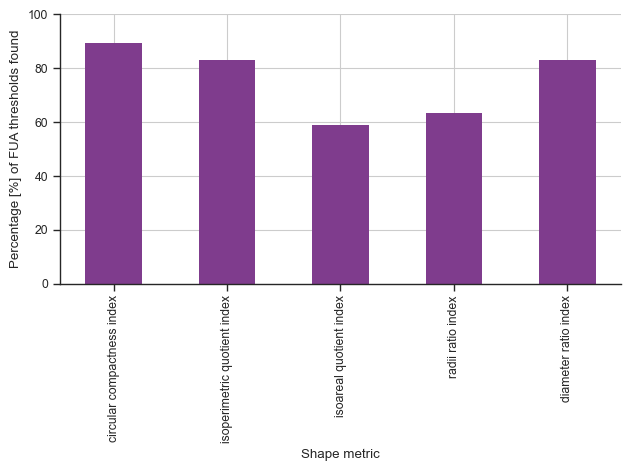

In [11]:
# which metric is most successful at identifying a threshold for each FUA?

thresholds_found = [
    sum([results[city][option]["threshold"] != False for city in results.keys()])
    for option in options
]
thresholds_found_pct = [100 * t / len(results.keys()) for t in thresholds_found]

fig, ax = plt.subplots(1, 1)
ax.bar(x=option_labels, height=thresholds_found_pct, width=mybarwidth)
ax.set_ylim((0, 100))
ax.set_xticklabels(option_labels, rotation=90)
ax.set_xlabel("Shape metric")
ax.set_ylabel("Percentage [%] of FUA thresholds found")
# ax.set_title("Comparison of metrics: what percentage of thresholds could be found?");

fig.savefig("../plots/peaks/stats/metric_percentages.png", dpi=300)

/var/folders/b0/lkvf88hn0673f5dlj9z0_2dr0000gn/T/ipykernel_23661/2873066480.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(option_labels, rotation=90)


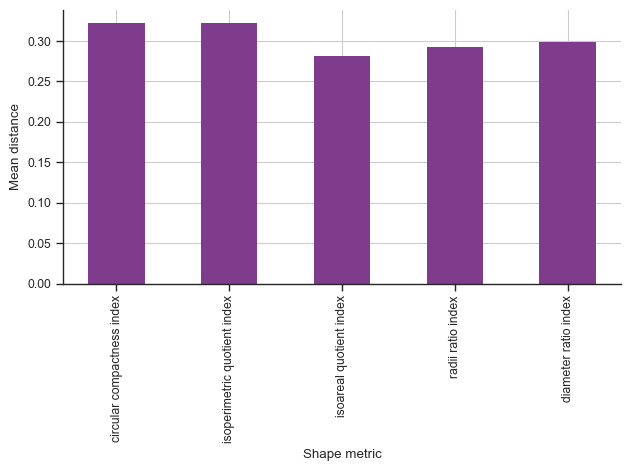

In [12]:
fig, ax = plt.subplots(1, 1)

mean_distances_found = [
    numpy.average(
        [
            results[city][option]["y_diff_max"]
            for city in results.keys()
            if results[city][option]["threshold"] != False
        ]
    )
    for option in options
]

ax.bar(x=option_labels, height=mean_distances_found, width=mybarwidth)
ax.set_xticklabels(option_labels, rotation=90)
# ax.set_ylim((0,1))
ax.set_xlabel("Shape metric")
ax.set_ylabel("Mean distance")
# ax.set_title(
#     "Comparison of metrics: how pronounced are the thresholds that could be found?"
# )

fig.savefig("../plots/peaks/stats/metric_thresholds.png", dpi=300)

Print the actual values.

In [13]:
thresholds_found_pct, thresholds_found, mean_distances_found

([89.31297709923665,
  83.20610687022901,
  58.778625954198475,
  63.3587786259542,
  83.20610687022901],
 [117, 109, 77, 83, 109],
 [0.32181606181658595,
  0.32237192509147755,
  0.28179518731316544,
  0.292788437639976,
  0.2989591925415576])

Check if they agree on FUAs.

In [14]:
bools = {
    option: numpy.asarray(
        [results[city][option]["threshold"] != False for city in results.keys()]
    )
    for option in options
}

Check if isoperimetric quotient and diameter ratio found the same 109 cases.

In [20]:
(bools["isoperimetric_quotient_index"] == bools["diameter_ratio_index"]).all()

False

Is there any that did detect threshold where circular compactness did not?

In [16]:
no_circom = bools["circular_compactness_index"] == False
no_circom_names = numpy.asarray(list(results.keys()))[no_circom]
for option in options:
    if bools[option][no_circom].any():
        print(f"{option}: {no_circom_names[bools[option][no_circom]]}")

isoperimetric_quotient_index: ['Ibadan']
isoareal_quotient_index: ['Tanta' 'Ibadan']
radii_ratio_index: ['Ibadan']
diameter_ratio_index: ['Dhaka' 'Jombang' 'Recife']
